<a href="https://colab.research.google.com/github/DataScienceUB/DeepLearningMaster2019/blob/master/11_Non%20supervised%20learning%20I%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non supervised learning

> Reminder: *In general Learning from Data is a scientific discipline that is concerned with the design and development of algorithms that allow computers to infer (from data) a model that allows compact representation (unsupervised learning) and/or good generalization (supervised learning).*

## Autoencoders

Suppose we have only a set of unlabeled training examples $x_1,x_2,x_3, \dots $, where $x_i \in \mathbb{R}^n$. 

An autoencoder neural network is an *unsupervised learning* algorithm that applies backpropagation and uses a loss function that is optimal when setting the target values to be equal to the inputs, $y_i=x_i$.

Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. 

To build an autoencoder, you need three things: an **encoding function**, a **decoding function**, and a **distance function** to measure the amount of information loss between your data and the decompressed representation.

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/autoencoder.jpg?raw=1" alt="" style="width: 700px;"/>
Source: https://blog.keras.io/building-autoencoders-in-keras.html
</center>

The ideal autoencoder model balances the following:

+ Sensitive to the inputs enough to accurately build a reconstruction.
+ Insensitive enough to the inputs that the model doesn't simply memorize or overfit the training data.

Two practical applications of autoencoders are **data denoising**, and **dimensionality reduction** for data visualization. 

With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other linear techniques.

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [0]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# this is the size of our encoded representations       
encoding_dim = 32  # 32 floats -> compression of factor 24.5, 
                   # assuming the input is 784 floats

input_img = Input(shape=(784,))

# encoded representation of the input
encoding_layer = Dense(encoding_dim, 
                       activation='relu')
encoded = encoding_layer(input_img)

# lossy reconstruction of the input
decoding_layer = Dense(784, 
                       activation='sigmoid')
decoded = decoding_layer(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model and a separate decoder model:

In [11]:
# this model maps an input to its encoded representation
encoding_model = Model(input_img, encoded)

# create a placeholder for an encoded input
# and create the decoder model
encoded_input = Input(shape=(encoding_dim,))
decoding_model = Model(encoded_input, decoding_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

Instructions for updating:
Use tf.cast instead.


Let's prepare our input data. 

In [12]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train, 
                x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0709 - val_loss: 0.0422
Epoch 2/20
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0354 - val_loss: 0.0297
Epoch 3/20
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0267 - val_loss: 0.0233
Epoch 4/20
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0215 - val_loss: 0.0192
Epoch 5/20
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0181 - val_loss: 0.0163
Epoch 6/20
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0157 - val_loss: 0.0145
Epoch 7/20
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0141 - val_loss: 0.0131
Epoch 8/20
60000/60000 [==============================] - 1s 15us/sample - loss: 0.0130 - val_loss: 0.0122
Epoch 9/20
60000/60000 [==============================] - 1s 15us/sa

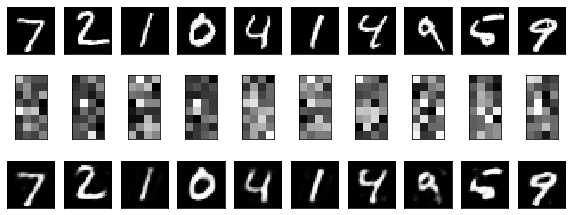

In [13]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoding_model.predict(x_test)
decoded_imgs = decoding_model.predict(encoded_imgs)

import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display

plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, n, i + 1+ n)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Adding depth and sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32 neurons). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). 

Another way to constrain the representations to be compact is to add a **sparsity contraint** on the activity of the hidden representations, so fewer units would "fire" at a given time. 

For any given observation, we'll encourage our network to learn an encoding and decoding which only relies on activating a small number of neurons. It's worth noting that this is a different approach towards regularization, as we normally regularize the weights of a network, not the activations.

In Keras, this can be done by adding an ``activity_regularizer`` to our Dense layer:

In [17]:
#autoencoder.reset_states()
#encoder.reset_states()
#decoder.reset_states()

from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model



input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu',activity_regularizer=l1(10e-5))(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

encoding_model = Model(input_img, encoded)  

autoencoder.compile(optimizer='adam', 
                    loss='mse',
                    )

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0717 - val_loss: 0.0445
Epoch 2/100
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0351 - val_loss: 0.0291
Epoch 3/100
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0269 - val_loss: 0.0242
Epoch 4/100
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0232 - val_loss: 0.0217
Epoch 5/100
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0212 - val_loss: 0.0201
Epoch 6/100
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0199 - val_loss: 0.0190
Epoch 7/100
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0188 - val_loss: 0.0181
Epoch 8/100
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0180 - val_loss: 0.0173
Epoch 9/100
60000/60000 [==============================] - 1s 20us/sample - loss: 0.01

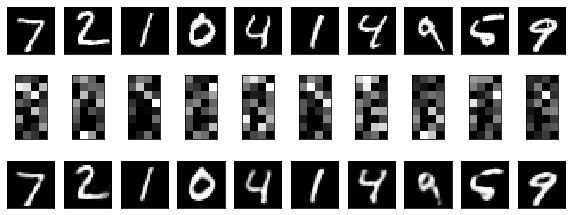

In [19]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoding_model.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, n, i + 1+ n)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional Autoencoders

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. 

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_img = Input(shape=(28, 28, 1))  

x = Conv2D(16, (3, 3), padding="same", activation="relu")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(8, (3, 3), padding="same", activation="relu")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(8, (3, 3), padding="same", activation="relu")(x)

encoded = MaxPooling2D((2, 2), padding="same")(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), padding="same", activation="relu")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), padding="same", activation="relu")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation="relu")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)

# at this point the representation is (28, 28, 1) i.e. 784-dimensional

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

In [41]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test)
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 78us/sample - loss: 25.2677 - val_loss: 18.6629
Epoch 2/20
60000/60000 [==============================] - 3s 53us/sample - loss: 17.9667 - val_loss: 16.4953
Epoch 3/20
60000/60000 [==============================] - 3s 53us/sample - loss: 16.5697 - val_loss: 15.7250
Epoch 4/20
60000/60000 [==============================] - 3s 53us/sample - loss: 15.8787 - val_loss: 15.1161
Epoch 5/20
60000/60000 [==============================] - 3s 57us/sample - loss: 15.4475 - val_loss: 14.7380
Epoch 6/20
60000/60000 [==============================] - 3s 56us/sample - loss: 15.1299 - val_loss: 14.3923
Epoch 7/20
60000/60000 [==============================] - 3s 57us/sample - loss: 14.8631 - val_loss: 14.1549
Epoch 8/20
60000/60000 [==============================] - 3s 57us/sample - loss: 14.6402 - val_loss: 13.9727
Epoch 9/20
60000/60000 [==============================] - 3s 56us/sample - los

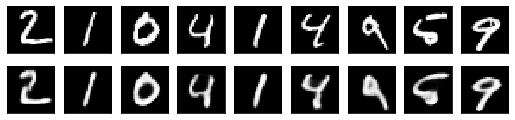

In [42]:
decoded_imgs = autoencoder.predict(x_test)

import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(10, 2))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising autoencoders

Another approach towards developing a generalizable model is to slightly corrupt the input data but still maintain the uncorrupted data as our target output.

With this approach, our model isn't able to simply develop a mapping which memorizes the training data because our input and target output are no longer the same.

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/denoised_digits.png?raw=1" alt="" style="width: 700px;"/> 
(Source: https://blog.keras.io/building-autoencoders-in-keras.html)
</center>

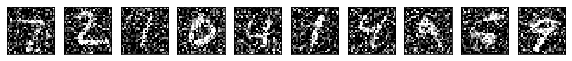

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(10, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [44]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(784, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(x_train_noisy, x_train, 
          epochs=100,
          batch_size=256,
          shuffle=True,
          validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 51us/sample - loss: 0.2608 - val_loss: 0.1997
Epoch 2/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1870 - val_loss: 0.1731
Epoch 3/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1669 - val_loss: 0.1597
Epoch 4/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1565 - val_loss: 0.1515
Epoch 5/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1503 - val_loss: 0.1466
Epoch 6/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1457 - val_loss: 0.1436
Epoch 7/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1422 - val_loss: 0.1397
Epoch 8/100
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1392 - val_loss: 0.1373
Epoch 9/100
60000/60000 [==============================] - 1s 23us/sample - loss: 0.13

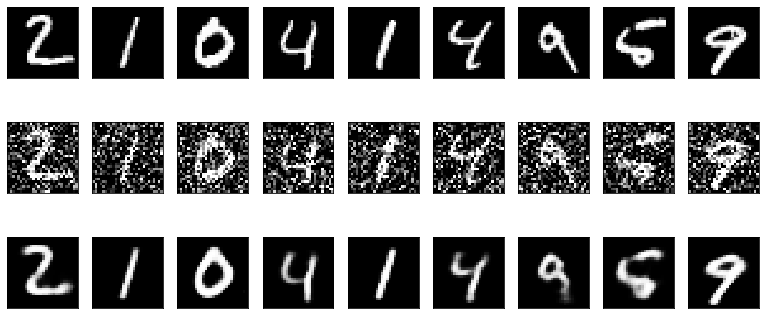

In [45]:
decoded_imgs = model.predict(x_test)
n = 10
plt.figure(figsize=(15, 6))
for i in range(1, n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display noisy
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational Autoencoders

A variational autoencoder is an autoencoder that adds probabilistic constraints on the representations being learned. 

> When using probabilistic models, **compressed representation** is called **latent variable model**. 

So, instead of learning a function this model is learning a probabilistic distribution function that models your data.

> Why? Standard autoencoders are not suited to work as a generative model. If you pick a random value for your decoder you won't get necessarily a good reconstruction: the value can far away from any previous value the network has seen before! That's why attaching a probabilistic model to the compressed representation is a good idea! 

For sake of simplicity, let's use a standard normal distribution to define the distribution of compressed inputs ($\mathbf V$) the decoder will receive. 

The architecture of a variational autoencoder (VAE) is thus:

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/vae1.png?raw=1" alt="" style="width: 300px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

We want the decoder to take any point taken from a standard normal distribution to return a reasonable element of our dataset:

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/vae2.png?raw=1" alt="" style="width: 500px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

Let's consider the encoder role in this architecture. 

In a traditional autoencoder, the encoder model takes a sample from data and returns a single point in the latent space, which is then passed to the decoder.

In VAE the encoder instead produces (the parameters of) a probability distribution in the latent space:

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/vae3.png?raw=1" alt="" style="width: 500px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

These distributions are (non standard) Gaussians of the same dimensionality as the latent space. 

### Implementation

First, let’s implement the encoder net, which takes input $X$ and outputs two things: $\mu(X)$ and $\Sigma(X)$, the parameters of the Gaussian. Our encoder will be based in a convolutional neural net. 

In this example our latent variable is two dimensional, so that we could easily visualize it.

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = layers.Input(shape=img_shape)

# encoder

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Up to now we have an encoder that takes images and produce (the parameters of) a pdf in the latent space.  

The decoder takes points in the latent space and return reconstructions.

How do we connect both models? By sampling from the produced distribution!


<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/vae4.png?raw=1" alt="" style="width: 400px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

To this end we will implement a *random variate reparameterisation*: the substitution of a random variable by a deterministic transformation of a simpler random variable.

There are several methods by which non-uniform random numbers, or random variates, can be generated. The most popular methods are the **one-liners**, which give us the simple tools to generate random variates in one line of code, following the classic paper by Luc Devroye (Luc Devroye, Random variate generation in one line of code, Proceedings of the 28th conference on Winter simulation, 1996).

In the case of a Gaussian, we can use the following algorithm:
+ Generate $\epsilon \sim \mathcal{N}(0;1)$.
+ Compute a sample from $\mathcal{N}(\mu; RR^T)$ as $\mu + R \epsilon$.

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Now we can create the decoder net. In order to be coherent with our previous definitions, we must assure that points sampled fron the latent space fit a standard normal distribition, but the encoder is producing non standard normal distributions. So, we must add a constraint for getting something like this:

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/vae5.png?raw=1" alt="" style="width: 700px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

In order to impose this constraint in the loss function by using the Kullback-Leibler divergence.

> The Kullback–Leibler divergence is a measure of how one probability distribution diverges from a second expected probability distribution. 
For discrete probability distributions $P$ and $Q$, the Kullback–Leibler divergence from $Q$ to $P$ is defined to be
$$ D_{\mathrm {KL} }(P\|Q)=\sum _{i}P(i)\,\log {\frac {P(i)}{Q(i)}}. $$

The rest of the loss function must take into account the "reconstruction" error.


Deconvolution or transposed convolution layer: https://github.com/vdumoulin/conv_arithmetic

In [50]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

class CustomVariationalLayer(layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

from tensorflow.keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 28, 28, 32)   320         input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_51[0][0]                  
__________________________________________________________________________________________________
conv2d_53 

### Training a VAE

How do we train a model that have a sampling step? 

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/vae_sampling.png?raw=1" alt="" style="width: 800px;"/> 
</center>

In fact this is not a problem! By using the *one-liner* method for sampling we have expressed the latent distribution in a way that its parameters are factored out of the parameters of the random variable so that backpropagation can be used to find the optimal parameters of the latent distribution. For this reason this method is called *reparametrization trick*.

By using this trick we can train end-to-end a VAE with backpropagation.

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 23s 390us/sample - loss: 0.1809 - val_loss: 0.1813
Epoch 2/25
60000/60000 [==============================] - 23s 386us/sample - loss: 0.1805 - val_loss: 0.1810
Epoch 3/25
60000/60000 [==============================] - 23s 386us/sample - loss: 0.1802 - val_loss: 0.1810
Epoch 4/25
60000/60000 [==============================] - 25s 409us/sample - loss: 0.1798 - val_loss: 0.1799
Epoch 5/25
60000/60000 [==============================] - 23s 386us/sample - loss: 0.1794 - val_loss: 0.1795
Epoch 6/25
60000/60000 [==============================] - 24s 399us/sample - loss: 0.1792 - val_loss: 0.1804
Epoch 7/25
60000/60000 [==============================] - 25s 409us/sample - loss: 0.1790 - val_loss: 0.1794
Epoch 8/25
60000/60000 [==============================] - 23s 386us/sample - loss: 0.1788 - val_loss: 0.1788
Epoch 9/25
60000/60000 [==============================] - 23s 386us/sample - l

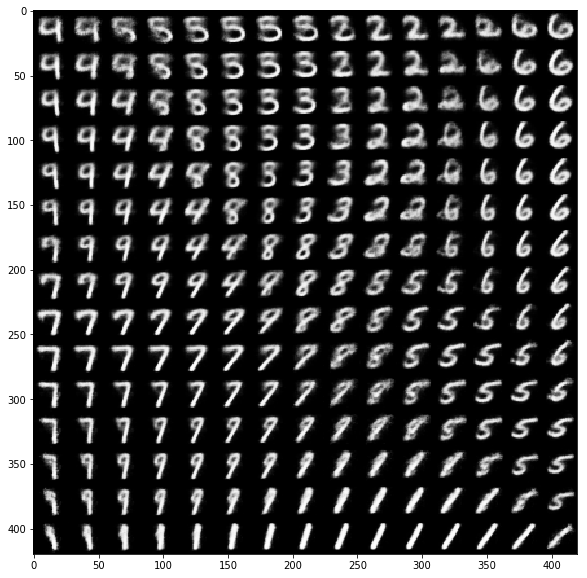

In [52]:
# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=25,
        batch_size=batch_size,
        validation_data=(x_test, None))

import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### Conditional VAE

What about producing specific number instances on demand?

We can do this by adding an extra input (as a one-hot encoding) to both the encoder and the decoder:

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/vae6.png?raw=1" alt="" style="width: 400px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

To generate an image of a particular number just feed that number in the decoder along with a random point in the latent space.

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/vae7.png?raw=1" alt="" style="width: 600px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

The latent space is no longer encoding what number are you dealing with (because this is already encoded in the extra input!). Instead, it is encoding information such as stroke width, angle, etc.

## Bibliography

+ Doersch, Carl. “Tutorial on variational autoencoders.” arXiv preprint arXiv:1606.05908 (2016).
+ Kingma, Diederik P., and Max Welling. “Auto-encoding variational bayes.” arXiv preprint arXiv:1312.6114 (2013).